Starcraft Rank Prediction by
Vivi B. Ngo

In [2]:
#Libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from scipy.stats import shapiro
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ETL

In [3]:
starcraft_df = pd.read_csv('/Users/vivib.ngo/desktop/starcraft_player_data.csv')

In [4]:
starcraft_df

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.000000,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.000000,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.000000,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.000000,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.000000,0.000019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,10089,8,?,?,?,259.6296,0.020425,0.000743,9,0.000621,0.000146,0.004555,18.6059,42.8342,6.2754,46,0.000877,5,0.000000,0.000000
3391,10090,8,?,?,?,314.6700,0.028043,0.001157,10,0.000246,0.001083,0.004259,14.3023,36.1156,7.1965,16,0.000788,4,0.000000,0.000000
3392,10092,8,?,?,?,299.4282,0.028341,0.000860,7,0.000338,0.000169,0.004439,12.4028,39.5156,6.3979,19,0.001260,4,0.000000,0.000000
3393,10094,8,?,?,?,375.8664,0.036436,0.000594,5,0.000204,0.000780,0.004346,11.6910,34.8547,7.9615,15,0.000613,6,0.000000,0.000631


In [5]:
#Remove irrelavent columns
starcraft_df = starcraft_df.drop('GameID', axis=1)

In [6]:
#Count how many non-int rows there are
non_integer_rows = starcraft_df[~starcraft_df.apply(lambda x: pd.to_numeric(x, errors='coerce').notnull().all(), axis=1)]
non_integer_rows
len(non_integer_rows)

57

The Professional Leagues coded 1-8 are not actual ranks within Starcraft, the highest rank for Starcraft is Grandmaster, hence it will be removed, however if was needed to be included then imputation method could be used to replace the missing values. 

In [7]:
#Remove rows contain '?'
newstar_df = starcraft_df[~starcraft_df.isin(['?']).any(axis=1)]
newstar_df

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,4,20,8,400,158.1390,0.013829,0.000504,7,0.000217,0.000313,0.003583,36.3990,66.2718,4.5097,30,0.001035,7,0.0,0.000287
3336,5,16,56,1500,186.1320,0.006951,0.000360,6,0.000083,0.000166,0.005414,22.8615,34.7417,4.9309,38,0.001343,7,0.0,0.000388
3337,4,21,8,100,121.6992,0.002956,0.000241,8,0.000055,0.000208,0.003690,35.5833,57.9585,5.4154,23,0.002014,7,0.0,0.000000
3338,3,20,28,400,134.2848,0.005424,0.000182,5,0.000000,0.000480,0.003205,18.2927,62.4615,6.0202,18,0.000934,5,0.0,0.000000


# EDA

In [8]:
for i in range(1, 9):
    length = len(starcraft_df[starcraft_df['LeagueIndex'] == i])
    print(f"Length of LeagueIndex {i}: {length}")

Length of LeagueIndex 1: 167
Length of LeagueIndex 2: 347
Length of LeagueIndex 3: 553
Length of LeagueIndex 4: 811
Length of LeagueIndex 5: 806
Length of LeagueIndex 6: 621
Length of LeagueIndex 7: 35
Length of LeagueIndex 8: 55


In [9]:
for i in range(1, 9):
    length = len(newstar_df[newstar_df['LeagueIndex'] == i])
    print(f"Length of LeagueIndex {i}: {length}")

Length of LeagueIndex 1: 167
Length of LeagueIndex 2: 347
Length of LeagueIndex 3: 553
Length of LeagueIndex 4: 811
Length of LeagueIndex 5: 804
Length of LeagueIndex 6: 621
Length of LeagueIndex 7: 35
Length of LeagueIndex 8: 0


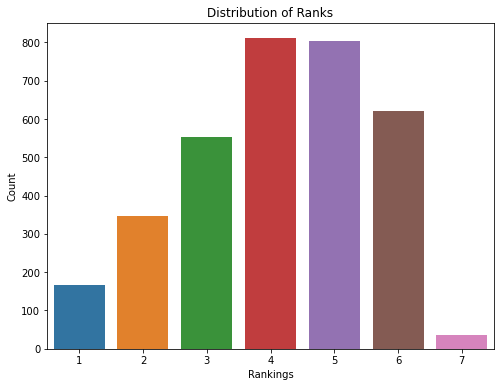

In [10]:

# Distribution of Ranks
plt.figure(figsize=(8, 6))
sns.countplot(data=newstar_df, x='LeagueIndex')
plt.title('Distribution of Ranks')
plt.xlabel('Rankings')
plt.ylabel('Count')
plt.show()

In [11]:
# Perform Shapiro-Wilk test
statistic, p_value = shapiro(newstar_df['LeagueIndex'])

# Print the test statistic and p-value
print("Shapiro-Wilk Test:")
print(f"Test Statistic: {statistic}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05  # significance level
if p_value > alpha:
    print("The ranking variable follows a normal distribution.")
else:
    print("The ranking variable does not follow a normal distribution.")

Shapiro-Wilk Test:
Test Statistic: 0.9304072856903076
P-value: 7.0790432604199156e-37
The ranking variable does not follow a normal distribution.


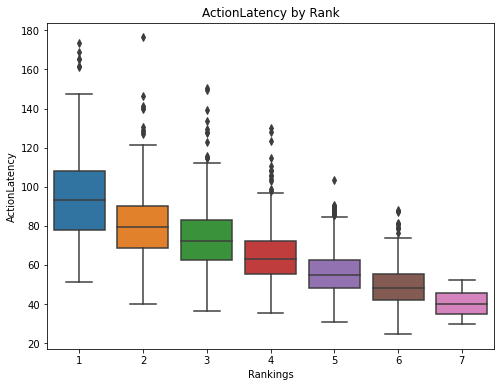

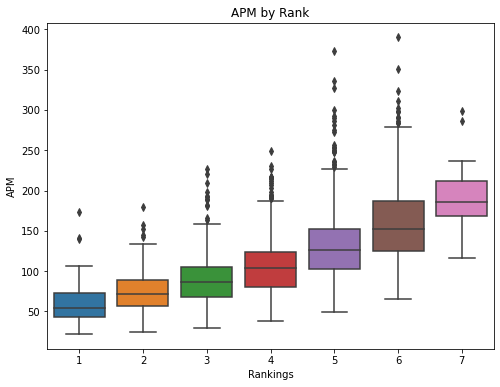

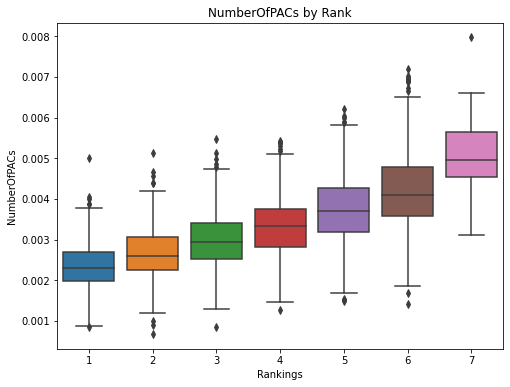

In [12]:
# Rank vs. Other Variables
variables_of_interest = ['ActionLatency', 'APM', 'NumberOfPACs']

for variable in variables_of_interest:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=newstar_df, x='LeagueIndex', y=variable)
    plt.title(f'{variable} by Rank')
    plt.xlabel('Rankings')
    plt.ylabel(variable)
    plt.show()

The higher the rank, the less outliers there are. The higher rank are more consistent in their performance, they're consistent in their performance and more consistent in metrics that would be considered good behavior or actions. The lower the variation, the more consistent the higher players are performing.

In [13]:
print(newstar_df['HoursPerWeek'].dtype)
print(newstar_df['TotalHours'].dtype)
newstar_df['HoursPerWeek'] = newstar_df['HoursPerWeek'].astype(int)
newstar_df['TotalHours'] = newstar_df['TotalHours'].astype(int)

object
object


/var/folders/gf/fgw2nqvj2lx6tnpfz0n7f8740000gn/T/ipykernel_51596/3231292657.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newstar_df['HoursPerWeek'] = newstar_df['HoursPerWeek'].astype(int)
/var/folders/gf/fgw2nqvj2lx6tnpfz0n7f8740000gn/T/ipykernel_51596/3231292657.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newstar_df['TotalHours'] = newstar_df['TotalHours'].astype(int)


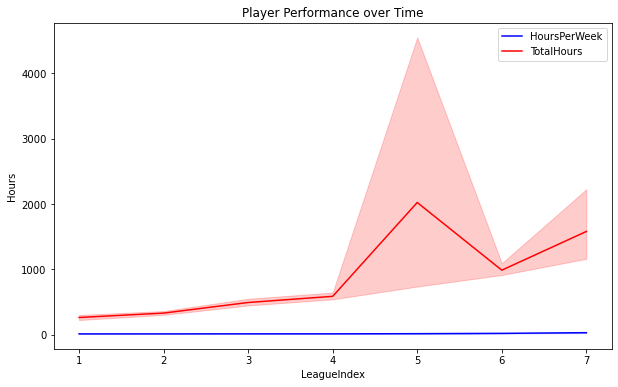

In [14]:
# Plotting the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=newstar_df, x='LeagueIndex', y='HoursPerWeek', color='blue', label='HoursPerWeek')
sns.lineplot(data=newstar_df, x='LeagueIndex', y='TotalHours', color='red', label='TotalHours')
plt.title('Player Performance over Time')
plt.xlabel('LeagueIndex')
plt.ylabel('Hours')
plt.legend()
plt.show()


# Analysis
Higher ranked players tend to have more hours dedicated to the game, which makes sense. At higher ranks such as grandmaster, players do not need to dedicated so many total hours overall to increase their rank if their main concern is to avoid elo decay, which we see the case for master and grandmaster

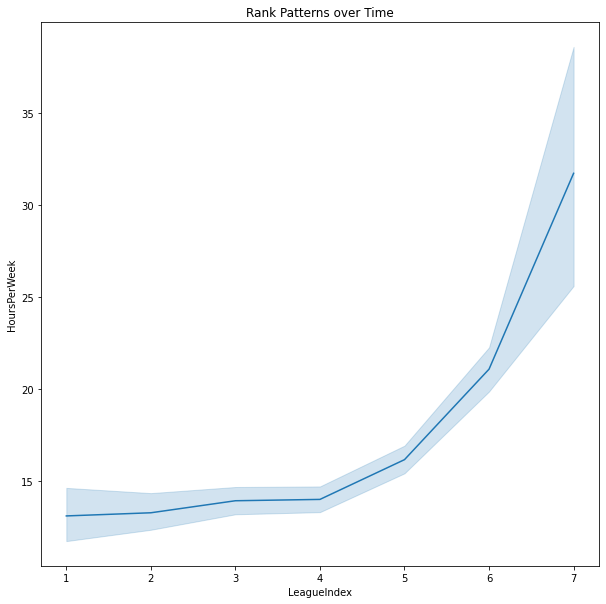

In [15]:
# Rank Patterns over Time (if applicable)
# Custom mapping of rankings to labels
# Sort the DataFrame by 'LeagueIndex'
newstar_df_sorted = newstar_df.sort_values('LeagueIndex')

plt.figure(figsize=(10, 10))
sns.lineplot(data=newstar_df_sorted, x='LeagueIndex', y='HoursPerWeek')
plt.title('Rank Patterns over Time')
plt.xlabel('LeagueIndex')
plt.ylabel('HoursPerWeek')

plt.show()

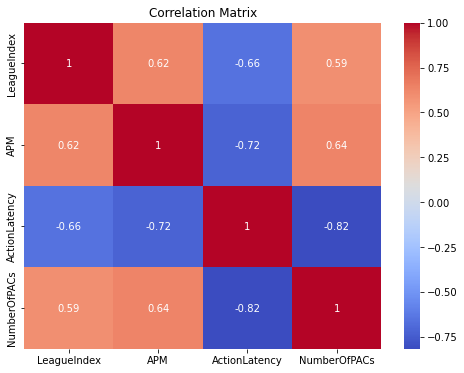

In [16]:
# Correlation Analysis : Pick variables of interest
correlation_matrix = newstar_df[['LeagueIndex', 'APM', 'ActionLatency', 'NumberOfPACs']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Analysis

APM, NumberOfPACs, and LeagueIndex have a positive correlation coefficient, which indicates a positive linear relationship, meaning that as APM increases, LeagueIndex increases proportionally. ActionLatency and LeagueIndex have a negative linear relationship, meaning that as ActionLatency decreases, LeagueIndex increases. 

In [17]:
# Rank Comparison
rank_comparison = newstar_df.groupby('LeagueIndex').mean()
rank_comparison

,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
LeagueIndex,,,,,,,,,,,,,,,,,
1,13.125749,264.191617,59.539277,0.001081,0.000185,3.215569,0.000028,0.000208,0.002363,65.654987,95.404977,4.548287,18.730539,0.000626,5.826347,0.000015,0.000042
2,13.296830,331.409222,74.780917,0.001536,0.000222,3.351585,0.000045,0.000276,0.002650,53.788886,81.270053,5.005949,19.824207,0.000801,6.074928,0.000024,0.000076
3,13.949367,493.792043,89.971260,0.002188,0.000282,3.687161,0.000056,0.000332,0.002976,46.143882,73.697301,5.163282,20.506329,0.000919,6.368897,0.000045,0.000117
4,14.022195,588.006165,105.847166,0.003150,0.000340,3.971640,0.000075,0.000368,0.003310,41.041426,64.793765,5.236971,22.019729,0.001006,6.573366,0.000065,0.000138
5,16.179104,2024.493781,131.578332,0.004980,0.000414,4.703980,0.000115,0.000427,0.003744,34.711566,56.078723,5.471087,23.065920,0.001168,6.701493,0.000076,0.000176
6,21.088567,988.405797,158.683211,0.007437,0.000512,5.521739,0.000156,0.000473,0.004231,30.207895,48.947837,5.475560,24.307568,0.001211,6.869565,0.000077,0.000182
7,31.714286,1581.028571,189.555686,0.009418,0.000723,6.771429,0.000340,0.000570,0.005111,22.978160,40.342903,5.226089,28.028571,0.001238,7.028571,0.000082,0.000267


# Analysis
The higher the average APM, NumberOfPACs, and lower ActionLatency, shows a an increase in rank/LeagueIndex. This is expected, players who are more skilled should have a lower reaction time and higher action per minute, being able to efficiently think about a counterplay/contingecny plan and executing are good indicators of a well seasoned player. NumberOfPACs could be seen as map awareness and how often the player is looking around, the panning of the map allows the player to gain more map awareness, when the player has more gains more information due to the awareness of the map, the higher their rank tends to be. 

# Feature Selection

The code uses a random forest classifier to train a supervised learning model on the dataset. It retrieves the feature importances from the trained model. These importances represent the relative importance of each feature in making predictions.  

In [18]:
# Separate the predictor variables (X) and the target variable (y)
X = newstar_df.drop('LeagueIndex', axis=1)  # Adjust the column name if needed
y = newstar_df['LeagueIndex']

In [19]:
X

,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,20,8,400,158.1390,0.013829,0.000504,7,0.000217,0.000313,0.003583,36.3990,66.2718,4.5097,30,0.001035,7,0.0,0.000287
3336,16,56,1500,186.1320,0.006951,0.000360,6,0.000083,0.000166,0.005414,22.8615,34.7417,4.9309,38,0.001343,7,0.0,0.000388
3337,21,8,100,121.6992,0.002956,0.000241,8,0.000055,0.000208,0.003690,35.5833,57.9585,5.4154,23,0.002014,7,0.0,0.000000
3338,20,28,400,134.2848,0.005424,0.000182,5,0.000000,0.000480,0.003205,18.2927,62.4615,6.0202,18,0.000934,5,0.0,0.000000


In [20]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
# Fit the classifier on the data
rf_classifier.fit(X, y)
# Get feature importances
importances = rf_classifier.feature_importances_
# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the DataFrame by importance values in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

A random forest classifier was used because we're trying to predict the rank/league index based on a set of variables. Random Forest is commonly used for classification tasks where the goal is to predict the class/category of an observation based on a set of input variables

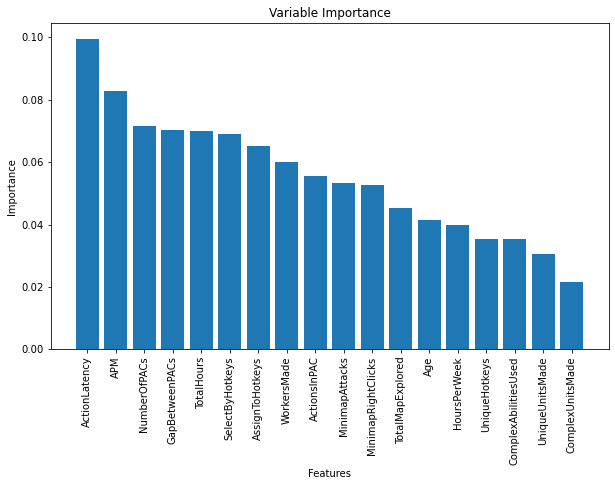

                 Feature  Importance
11         ActionLatency    0.099599
3                    APM    0.082927
9           NumberOfPACs    0.071648
10        GapBetweenPACs    0.070312
2             TotalHours    0.069979
4        SelectByHotkeys    0.069025
5        AssignToHotkeys    0.065149
14           WorkersMade    0.059959
12          ActionsInPAC    0.055704
7         MinimapAttacks    0.053354
8     MinimapRightClicks    0.052822
13      TotalMapExplored    0.045352
0                    Age    0.041396
1           HoursPerWeek    0.039762
6          UniqueHotkeys    0.035415
17  ComplexAbilitiesUsed    0.035226
15       UniqueUnitsMade    0.030699
16      ComplexUnitsMade    0.021672


In [21]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Variable Importance')
plt.show()

# Print the feature importance rankings
print(feature_importance_df)

# Random Forest Model

A random forest classifier was chosen for predicting player rankings based on performance since it's good at handling complex relationships, player performance data often contains intricate relationships and interactions between various perofrmance metrics. Random forest can effectively capture and model these complex relationships.

In [32]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier()

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred, zero_division = 0)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           1       0.38      0.38      0.38        24
           2       0.33      0.22      0.26        69
           3       0.32      0.31      0.32       102
           4       0.40      0.46      0.43       151
           5       0.35      0.45      0.40       157
           6       0.66      0.50      0.57       161
           7       0.00      0.00      0.00         4

    accuracy                           0.42       668
   macro avg       0.35      0.33      0.34       668
weighted avg       0.43      0.42      0.42       668



# Analysis
Precision is the proportion of correctly predicted instances of a specific LeagueIndex. A precision of 0.38 for LeagueIndex of 1 (Bronze) means that 38 of the instances predicted as LeagueIndex 1 were actually LeagueIndex 1(Bronze).

Recall is known as true positive rate, its the proportion of correctly predicted instances of a specific rank our of all the instances that actually belong to that rank. For example a recall of 0.38 for LeagueIndex 1(Bronze) means that 38% of the actual instances of LeagueIndex 1 were correctly predicted as Bronze.

The F1-score is the harmonic mean of precision and recall, it is a single metric that combines precision and recall. It is often used when there is an imbalance between class. 

Support refers to the number of instances in each rank in the test data.

Accuracy is the overall proportion of correctly predicted instances across all classes. It measures the overall performance of the model. The model is 42% accurate.

Macro average alculates the average performance across all ranks, giving equal weight to each rank, it provides an overall evaluation of the model's performance without considering rank imbalance.

Weighted average calculates the average performance across all ranks, but takes into account the number of instances of each rank. It provides an evaluation that considers rank imbalance by giving more weight to ranks with more instances.

Since there were no instances predicted as Grandmaster(rank 7), the precision, recall, and F1-score for grandmaster are all 0. This can happen when grandmaster rank is underrepresented in the training data, leading the model to have difficulty predicting this rank accurately.

# Tree Plot

In [25]:
from sklearn import tree

# Get the first tree from the Random Forest classifier
selected_features = ['APM', 'ActionLatency', 'NumberOfPACs']
X_selected = X[selected_features]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(max_depth = 3)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

# Get one of the trees from the Random Forest classifier (e.g., the first tree)
tree_estimator = rf_classifier.estimators_[0]

# configure plot size and spacing
plt.figure(figsize=(20, 20), dpi=1000)
# plt.subplots_adjust(left=0.1, right=1, top=1, bottom=0.8)
#plot the tree
tree.plot_tree(tree_estimator, feature_names=selected_features, class_names=['1', '2', '3', '4', '5', '6', '7'], filled=True, max_depth=3, fontsize=10)

plt.show()

              precision    recall  f1-score   support

           1       0.39      0.29      0.33        24
           2       0.25      0.10      0.14        69
           3       0.33      0.29      0.31       102
           4       0.33      0.48      0.39       151
           5       0.31      0.43      0.36       157
           6       0.59      0.34      0.43       161
           7       0.00      0.00      0.00         4

    accuracy                           0.36       668
   macro avg       0.31      0.28      0.28       668
weighted avg       0.38      0.36      0.35       668



/Users/vivib.ngo/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vivib.ngo/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vivib.ngo/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Analysis

If the ActionLatency is <= 56.705, the tree will follow the left branch from this node. The Gini impurity score = 0.807 suggests that the samples in this node are distributed across multiple LeagueIndex rather than being predominantly in a single LeagueIndex. Samples = 1674 represents the number of samples(data points) that reached this node during the training processes. The value = [118, 277, 482, 634, 639, 490, 30] shows the distribution of target LeagueIndex, the values correspond to the counts of each LeagueIndex Rank, for example there are 118 samples with LeagueIndex 1.

 # Hypothetical: 
 After seeing your work, your stakeholders come to you and say that they can collect more data, but want your guidance before starting. How would you advise them based on your EDA and model results?

Based on the EDA and model results for Starcraft 2, here's how I would advise the stakeholders regarding collecting more data : I see that the variables that hold the most weight in predicting a player's rank are ActionLatency, APM, NumberOfPACs, GapBetweenPACs, & TotalHours. With this information some variables that I think are beneficial to gather: 

1. Win Rate: The win rate of a player can be a strong predictor of their rank. Players with higher win rates are likely to have higher ranks. 
2. Game Duration: The average duration of the player's games can provide insights into their playstyle and strategy. Longer game durations may indeicate more strategic gameplay. 
3. Race: The race chosen by a player (Protoss, Terran, or Zerg) can also be a predictor of their rank. Different races have unique strengths and weaknesses, and players may have varying levels of proficiency with each race.
4.Experience: The number of games played or the player's experience level can be indicative of their skill and rank. More experienced players tend to have higher ranks.
5. Average Resource Collection Rate: The rate at which a player collects resources (minerals and gas) during the game can reflect their ability to efficiently manage their economy and build an army.

 The data provided does not contain enough data for grandmaster, although it is understandable that this rank does not have a lot of data since this league represents the top 200 players in each region, the data provided is not enough to get an accurate model. 

